# 腦溢血自動切割 (Intracerebral Hemorrhage Segmentation)

## 1. 前期準備

### 1.1 掛載 Google 雲端硬碟

In [15]:
# from google.colab import drive
# drive.mount("/content/drive")

### 1.2 套件庫

#### 1.2.1 安裝額外套件

In [16]:
# !pip install -U segmentation-models keras-applications image-classifiers efficientnet

#### 1.2.2 匯入套件庫

In [17]:
import os
import sys
import math
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import segmentation_models as sm
from tqdm.notebook import tqdm, trange

#### 1.2.3 套件版本

In [18]:
print(f"Python: {sys.version}")
print(f"Tensorflow: {tf.__version__}")
print(f"Tensorflow-Keras: {keras.__version__}")
print(f"Segmentation_model: {sm.__version__}")

Python: 3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]
Tensorflow: 2.10.0
Tensorflow-Keras: 2.10.0
Segmentation_model: 1.0.1


### 1.3 定義全域變數

In [19]:
PROJECT_DIR = os.path.abspath("/workspaces/Intracranial-Hemorrhage/ICH-Segmentation")
LOGS_DIR = os.path.join(PROJECT_DIR, "logs")
OUTPUT_DIR = os.path.join(PROJECT_DIR, "output")
DATASET_DIR = os.path.join(PROJECT_DIR, "datasets")
ICH420_DATASET = os.path.join(DATASET_DIR, "ICH_420")

## 2. 資料集


### 2.1 ICH420 資料集

#### 2.1.1 抓取所有 TFRecord 檔案

In [20]:
tfrecords_filelist = tf.io.gfile.glob(
    os.path.join(ICH420_DATASET, "TFRecords", "train", "*.tfrecord")
)

#### 2.1.2 將檔案資料載入為 TFRecord 格式

In [21]:
ich420_tfrecords = tf.data.TFRecordDataset(
    [tfrecords_filelist],
    compression_type="GZIP",
    num_parallel_reads=tf.data.AUTOTUNE
)

#### 2.1.3 TFRecord 資料解析

In [22]:
def _ich_tfrecord_parser(example):
  features_description = {
      "filename": tf.io.FixedLenFeature([], tf.string),
      "number": tf.io.FixedLenFeature([], tf.int64),
      "sample": tf.io.FixedLenFeature([], tf.int64),
      "image_raw": tf.io.FixedLenFeature([], tf.string),
      "mask_raw": tf.io.FixedLenFeature([], tf.string)
  }

  example = tf.io.parse_single_example(example, features_description)
  image = tf.io.decode_png(example["image_raw"], channels=1)
  mask = tf.cast(
      tf.io.decode_png(example["mask_raw"], channels=1),
      dtype=tf.float32
  )
  sample = tf.cast(example["sample"], tf.bool)

  return (image, mask), sample

#### 2.1.4 TFRecord 資料集預處理

In [23]:
def load_dataset(
    tfrecords, 
    train_rate=0.8, 
    only_sample=None, 
    shuffle=True,
    repeat=False, 
    batch_size=1):
  # 解析資料集
  dataset = tfrecords.map(
      _ich_tfrecord_parser,
      num_parallel_calls=tf.data.AUTOTUNE,
      deterministic=False
  )
  
  # 提出指定的樣本類型 (None: 全部; True: 正樣本; False: 負樣本)
  if only_sample is not None:
    dataset = dataset.filter(lambda x, y: y == only_sample)
  
  dataset = dataset.map(
      lambda x, _: x,
      num_parallel_calls=tf.data.AUTOTUNE,
      deterministic=False
  )

  # 計算尺寸
  total_num = 1
  for total_num, _ in enumerate(tqdm(
      dataset, total=total_num, desc="Count"), start=1): 
    pass

  # 打散資料集
  dataset = dataset.shuffle(
      total_num, 
      reshuffle_each_iteration=False
  )
  
  # 分為訓練及與測試集
  train_num = int(total_num * train_rate)
  valid_num = total_num - train_num
  train_dataset = dataset.take(train_num)
  valid_dataset = dataset.skip(train_num)
  
  if shuffle:
    train_dataset = train_dataset.shuffle(
        1024
    )
  
  if repeat:
    train_dataset = train_dataset.repeat()

  train_dataset = train_dataset.batch(
      batch_size,
      drop_remainder=True,
      num_parallel_calls=tf.data.AUTOTUNE,
      deterministic=False
  )
  valid_dataset = valid_dataset.batch(
      batch_size,
      drop_remainder=True,
      num_parallel_calls=tf.data.AUTOTUNE,
      deterministic=False
  )

  train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
  valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
  
  return (train_dataset, valid_dataset), (train_num, valid_num)

## 3. 網路模型

### 3.1 UNet 模型

In [24]:
def UNet(
    backbone="efficientnetb3",
    encoder_weights=None,
    input_shape=(None, None, 1),
    optimizer=keras.optimizers.Adam(1e-4),
    loss=(sm.losses.DiceLoss() + (1 * sm.losses.BinaryFocalLoss())),
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)],
    jit_compile=False
):
  model = sm.Unet(
    backbone, 
    encoder_weights=encoder_weights, 
    input_shape=input_shape
  )
  model.compile(
      optimizer,
      loss=loss,
      metrics=metrics,
      jit_compile=jit_compile
  )

  return model

## 4. 訓練模型

### 4.1 超參數

In [25]:
BACKBONE = "efficientnetb3"
TRAING_NAME = "ICH420"
BATCH_SIZE = 4
EPOCH = 1
TRAINING_RATE = 0.8

In [ ]:
CALLBACKS = [
    keras.callbacks.TensorBoard(log_dir=LOGS_DIR),
    keras.callbacks.ModelCheckpoint(
        f"{TRAING_NAME}-" + "{epoch}.h5",
        save_weights_only=True,
        save_best_only=False
    ),
    keras.callbacks.ReduceLROnPlateau()
]

### 載入資料集

In [26]:
(x_dataset, y_dataset), (x_num, y_num) = load_dataset(
    ich420_tfrecords,
    train_rate=TRAINING_RATE, 
    only_sample=True, 
    shuffle=True,
    repeat=True, 
    batch_size=BATCH_SIZE
)

Count:   0%|          | 0/1 [00:00<?, ?it/s]

### 載入模型

In [27]:
model = UNet(
    backbone=BACKBONE,
    jit_compile=False
)

### 訓練

In [28]:
history = model.fit(
    x_dataset,
    epochs=EPOCH,
    steps_per_epoch=int(math.ceil(1. * x_num) / BATCH_SIZE),
    callbacks=[keras.callbacks.ReduceLROnPlateau()],
    validation_data=y_dataset,
    verbose=1
)

2022-11-09 16:29:42.649840: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-09 16:29:43.704970: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1378/1378 - 269s - loss: 1.0052 - iou_score: 0.5776 - f1-score: 0.5776 - val_loss: 1.0004 - val_iou_score: 0.9971 - val_f1-score: 0.9971 - lr: 1.0000e-04 - 269s/epoch - 195ms/step


### 訓練歷史圖

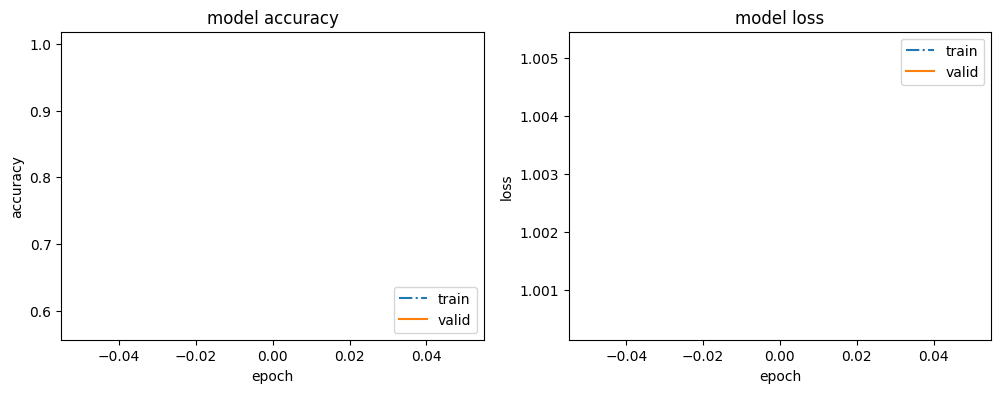

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['iou_score'],linestyle='-.')
plt.plot(history.history['val_iou_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()